In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.resnet_dropout
import models.resnet
import models.unet_model

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class VOCTransform(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, labels):
        labels = (labels * 255).squeeze(0).to(torch.long)
        labels[labels == 255] = 0
        return labels

from datasets.transforms import AddGaussianNoise

transforms_normalized = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # torchvision.transforms.GaussianBlur(kernel_size=101, sigma=2),
    torchvision.transforms.ToTensor(),
    # AddGaussianNoise(std=0.2),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    VOCTransform()
])


data_train = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="train", transform=transforms_normalized, target_transform=target_transforms)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                          batch_size=16,
                                          shuffle=False)



data_test = torchvision.datasets.VOCSegmentation(
    root="VOC", download=True, image_set="val", transform=transforms_normalized, target_transform=target_transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                          batch_size=16,
                                          shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


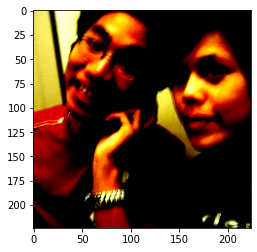

In [6]:
plt.imshow(data_test[7][0].permute((1,2,0)))


In [22]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

def decode_segmap(image, nc=22):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                             (128, 0, 0), (0, 128, 0), (128, 128,
                                                        0), (0, 0, 128), (128, 0, 128),
                             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                             (0, 128, 128), (128, 128, 128), (64,
                                                              0, 0), (192, 0, 0), (64, 128, 0),
                             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                             (192, 128, 0), (64, 0, 128), (192, 0,
                                                           128), (64, 128, 128), (192, 128, 128),
                             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                             (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128), (128, 128, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [4]:
model = torch.load("checkpoints/deeplab_resnet_finetune_no_dropout.pt")
model_dropout = torch.load("checkpoints/deeplab_resnet_finetune.pt")

# model = torch.load("checkpoints/VOC_segmentation_deeplabv3_mobilenet_v3_large.pt")
# model = torch.load("checkpoints/unet_unewighted.pt")


In [6]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
def add_dropout(model, block, prob, omitted_blocks=[]):

    for name, p in block.named_children():
        if any(map(lambda x: isinstance(p, x), omitted_blocks)):
            continue
        if isinstance(p, torch.nn.Module) or isinstance(p, torch.nn.Sequential):
            add_dropout(model, p, prob, omitted_blocks)

        if isinstance(p, torch.nn.ReLU):
            setattr(block, name, torch.nn.Sequential(torch.nn.ReLU(), torch.nn.Dropout2d(p=prob)))
            # return model
add_dropout(model, model, 0.05)

model.classifier[0].project[2] = torch.nn.ReLU()
# model.classifier[3]=torch.nn.ReLU()
# model.aux_classifier[2]=torch.nn.ReLU()

In [8]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [22]:
from tqdm import tqdm
import torchmetrics  

def compute_segmentation_loss_weights(dataset: dict, num_classes):
    counts = np.zeros(num_classes, dtype="int64")
    for _, _, _, gt in dataset:
        for i in range(num_classes):
            counts[i] += (gt == i).sum()
    all_count = counts.sum()
    weights = [np.sqrt(all_count / count) if count > 0 else 1.0 for count in counts]
    return weights


def train_model(model, num_epochs, optimizer, criterion, data_loaders, device):
    softmax = nn.Softmax(dim=1)
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}', flush=True)
        print('-' * 10, flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            running_entropy = 0.0
            running_maxes = 0.0
            numel = 0
            count = 0
            progress_bar = tqdm(data_loaders[phase])
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels
                numel += labels.numel()
                optimizer.zero_grad()
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)["out"]
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                probs = softmax(outputs).detach()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_maxes += torch.sum(torch.max(probs, dim=1)[0])

                epoch_loss = loss.item()
                iou = torchmetrics.functional.jaccard_index(preds, labels).item()
                dice = torchmetrics.functional.dice_score(preds, labels).item()
                epoch_acc = running_corrects.double() / numel
                # epoch_entropy = running_entropy / count
                epoch_avg_max = running_maxes / count
                progress_str = f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.2f} IOU: {iou:.2f} DICE: {dice:.2f} Avg. max. prob: {epoch_avg_max:.2f}'
                progress_bar.set_description(progress_str)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = train_model(
    model, 50, optimizer, criterion, data_loaders, device)

Epoch 1/50
----------


  0%|          | 0/92 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 7.80 GiB total capacity; 6.67 GiB already allocated; 13.19 MiB free; 6.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
# scaled_model.set_temperature(data_loader, device)

In [6]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        # print(iou(preds, labels))
        # return
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            mc_max_probs, mc_predictions = mc_means.max(axis=1)
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_max_probs = np.append(test_progress.dropout_max_probs, mc_max_probs)
            # test_progress.dropout_outputs.append(mc_means.numpy())

            # test_progress.dropout_variances = np.append(
            #     test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    # if mc_dropout_iters > 0:
    #     test_progress.dropout_outputs = np.concatenate(
    #         test_progress.dropout_outputs)
    return test_progress


progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

# progress_scaled = run_validation(
#     scaled_model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)    

  0%|          | 0/91 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [17]:
del progress

In [9]:
def iou(preds, labels):
    preds = F.one_hot(preds)
    labels = F.one_hot(labels)
    intersection = (preds & labels).sum((0,1,2))
    union = (preds | labels).sum((0,1,2))
    iou = (intersection) / (union)
    print(iou)
    
    return iou.nanmean()

preds = torch.Tensor(progress.predictions).to(torch.long)

preds_mcd = torch.Tensor(progress.dropout_predictions.reshape(progress.predictions.shape)).to(torch.uint8)


labels = torch.Tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

print(iou(preds, labels))
# torchmetrics.functional.jaccard_index(preds[:32], labels[:32],absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[32:64], labels[32:64], absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[:64], labels[:64], absent_score=torch.nan, reduction="none").nanmean()


tensor([0.8724, 0.7829, 0.0410, 0.7138, 0.5675, 0.6498, 0.8559, 0.7974, 0.7651,
        0.2436, 0.7879, 0.5905, 0.7240, 0.7408, 0.6649, 0.7656, 0.5223, 0.7347,
        0.4206, 0.8166, 0.6382])
tensor(0.6522)


NameError: name 'labels' is not defined

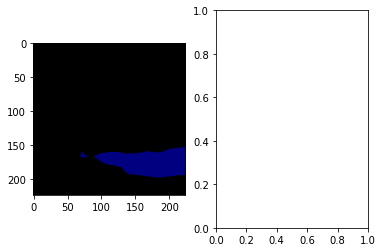

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(decode_segmap(progress.predictions[2]))
axs[1].imshow(decode_segmap(labels[2]))

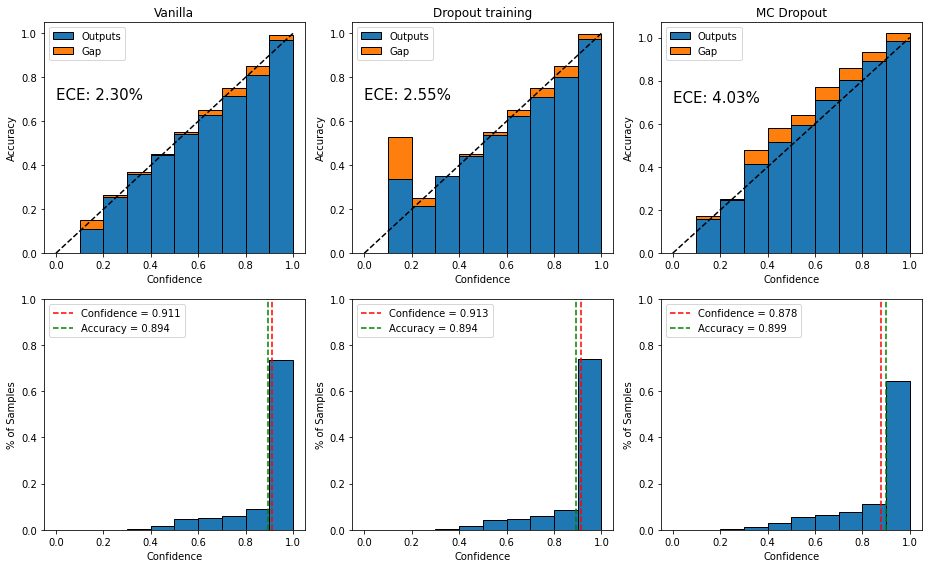

In [19]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)

# dropout_max_probs = progress.dropout_outputs.max(axis=1).ravel()

utils.visualisations.calibration_graph([
        ("Vanilla", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions.ravel()),
        ("Dropout training", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        ("MC Dropout", progress.dropout_max_probs, np.argsort(progress.dropout_max_probs), progress.dropout_predictions.ravel()),
        # ("Temp scaling", progress_scaled.max_probs, np.argsort(progress_scaled.max_probs), progress_scaled.predictions.ravel()),



    ],
    progress.labels,
    figsize=(13,8)
    )

plt.savefig("figures/voc_segmentation.pdf")

In [29]:
# curves = {
#     "Vanilla": utils.metrics.model_metrics(),
#     "Dropout training": utils.metrics.model_metrics(),
#     "MC Dropout":utils.metrics.model_metrics(),
# }

from datasets.transforms import AddGaussianNoise


for s in np.arange(0, 0.6, 0.05):

    transforms_normalized = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        # torchvision.transforms.GaussianBlur(kernel_size=101, sigma=2),
        # transforms.ColorJitter(brightness=s/2, saturation=s, contrast=s),
        torchvision.transforms.ToTensor(),
        AddGaussianNoise(std=s),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        VOCTransform()
    ])





    data_test = torchvision.datasets.VOCSegmentation(
        root="VOC", download=True, image_set="val", transform=transforms_normalized, target_transform=target_transforms)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                            batch_size=16,
                                            shuffle=False)


    print(f"Strength: {s}")

    progress = run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)
    # progress_dropout = run_validation(
    #     model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)



    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress.labels.ravel()
    labels_2d = torch.as_tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)


    max_probs = progress.max_probs.ravel()
    utils.metrics.update_model_metrics(None, max_probs, progress.predictions.ravel(), labels, bins, curves["Vanilla"], s)
    preds = torch.as_tensor(progress.predictions).to(torch.long)
    curves["Vanilla"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    curves["Vanilla"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))

    # max_probs = progress_dropout.max_probs.ravel()
    # utils.metrics.update_model_metrics(None, max_probs, progress_dropout.predictions.ravel(), labels, bins, curves["Dropout training"], s)
    # preds = torch.as_tensor(progress_dropout.predictions).to(torch.long)
    # curves["Dropout training"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    # curves["Dropout training"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))


    # max_probs = progress_dropout.dropout_max_probs.ravel()
    # utils.metrics.update_model_metrics(None, max_probs, progress_dropout.dropout_predictions, labels, bins, curves["MC Dropout"], s)
    # preds = torch.as_tensor(progress_dropout.dropout_predictions).reshape(progress_dropout.predictions.shape).to(torch.long)
    # curves["MC Dropout"].ious.append(utils.metrics.iou(preds, labels_2d, num_classes=21))
    # curves["MC Dropout"].mious.append(utils.metrics.mean_class_iou(preds, labels_2d, num_classes=21))

    del progress


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.0


Avg. acc.: 89.36: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.05


Avg. acc.: 87.68: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.1


Avg. acc.: 84.94: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.15000000000000002


Avg. acc.: 81.16: 100%|██████████| 91/91 [01:06<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.2


Avg. acc.: 76.89: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.25


Avg. acc.: 73.61: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.30000000000000004


Avg. acc.: 70.06: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.35000000000000003


Avg. acc.: 67.69: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.4


Avg. acc.: 65.82: 100%|██████████| 91/91 [01:05<00:00,  1.38it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.45


Avg. acc.: 64.62: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.5


Avg. acc.: 63.64: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Strength: 0.55


Avg. acc.: 63.41: 100%|██████████| 91/91 [01:05<00:00,  1.39it/s]


In [10]:
import pickle
with open("experiments/voc-segmentation-noise-dropout.pickle", "wb") as f:
    pickle.dump(curves,f)

In [16]:
import pickle
with open("experiments/voc-segmentation-noise-dropout.pickle", "rb") as f:
    curves = pickle.load(f)

In [28]:
curves["Vanilla"] = utils.metrics.model_metrics()

In [31]:
curves

{'Dropout training': <utils.metrics.model_metrics at 0x7fc27c46a760>,
 'MC Dropout': <utils.metrics.model_metrics at 0x7fc27c5c76a0>,
 'Vanilla': <utils.metrics.model_metrics at 0x7fc27f94b190>}

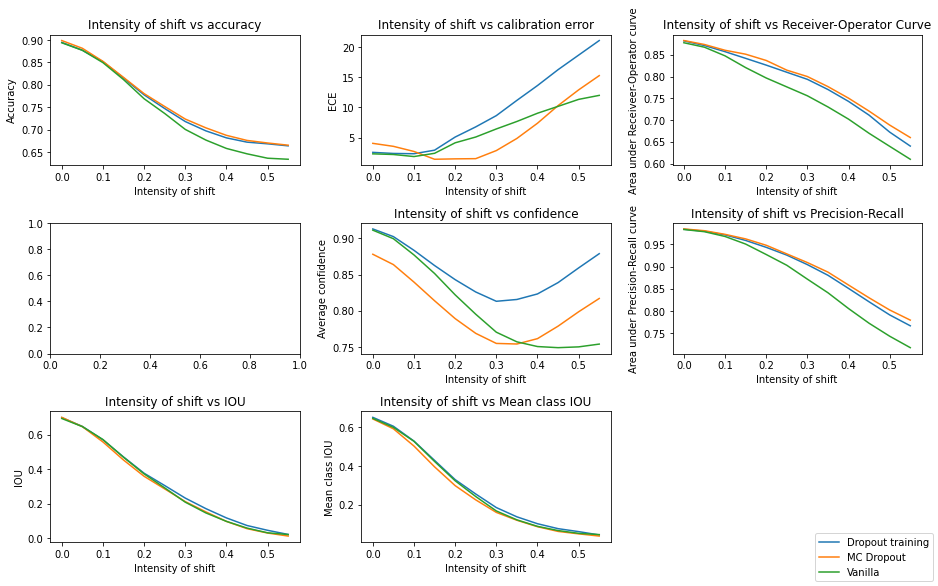

In [30]:
fig, axs = plt.subplots(3, 3, figsize=(13, 8))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    # ax = axs[1][0]
    # ax.plot(m.strengths, m.brier, label=name)
    # # ax.legend()
    # ax.set_title("Intensity of shift vs brier score")
    # ax.set_xlabel("Intensity of shift")
    # ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.aupr, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")

    ax = axs[2][0]
    ax.plot(m.strengths, m.ious, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs IOU")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("IOU")

    ax = axs[2][1]
    ax.plot(m.strengths, m.mious, label=name)
    # ax.legend()
    ax.set_title("Intensity of shift vs Mean class IOU")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Mean class IOU")

    axs[2][2].axis("off")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
fig.tight_layout()

# plt.savefig("figures/covid19-gaussian-noise.pdf")